# Modelo NeuralProphet

NeuralProphet se describe como un modelo entrenado con métodos de **Deep Learning**, brinda soluciones híbridas(Modelo híbrido) y produce componentes de pronóstico interpretables. Además, toma componentes de las **Redes Neuronales** como módulos autoregresivos y covariables.  
Es una alternativa a los modelos **ARIMA** y **ETS**, ya que el primero requiere de suposiciones restrictivas y el segundo tiene naturaleza paramétrica, lo que limita su rendimiento en aplicaciones del mundo real.

#### Prophet vs NeuralProphet

Para los diseñadores, Prophet carece de contexto local, que es necesario para pronosticar el futuro a corto plazo, y también de extensibilidad.  
NeuralProphet supera a Prophet en una **colección diversa de conjuntos de datos**(retardos de la variable y variables exógenas) del mundo real. Para pronosticar a corto y mediano plazo, NeuralProphet mejora la presición del pronóstico en un 55 a 92%.

#### Modelo NeuralProphet

El modelo NeuralProphet se define de la siguiente forma  
$$\hat{y_t}=T(t)+S(t)+E(t)+F(t)+A(t)+L(t)$$
donde,  
$T(t)$= Componente de tendencia.  
$S(t)$= Componente estacional.  
$E(t)$= Eventos y días festivos.  
$F(t)$= Variables exógenas conocidas en el futuro.  
$A(t)$= Autoregresión basada en tiempos pasados.  
$L(t)$= Observaciones rezagadas de variables exógenas.

### Tendencia

Para el modelo NeuralProphet la tendencia se modela como la combinación de un desplazamiento **$m$** y una taza de crecimiento **$k$**.  
$$T(t_1)=T(t_0)+k\Delta_t=m+k(t_1-t_0)$$
El número predeterminado de intervalos en el modelo es 10.

### Estacionalidad

Se utilizan componentes de Fourier para modelar la estacionalidad, con ellas se permite modelar múltiples estacionalidades.  
Se admiten patrones estacionales aditivos y multiplicativos. Cada periodicidad estacional $S^{*}_{p}$ puede configurarse individualmente para ser multiplicativa, en cuyo caso el componente se multiplica por la tendencia  

$$
S^{*}_{p}(t)=
\begin{cases}
S^{T}_{p}(t)=T(t)\cdot S(t) & \text{si $S_p$ es multiplicativo }\\
\\
S_{p}(t) & \text{en caso contrario }
\end{cases}
$$

Se puede activar estacionalidad diaria, semanal y/o anual. Estas se pueden activar si al menos dos periodos completos del conjunto de datos están disponibles. Por ejemplo, si mi serie es diaria entonces necesito tener información de dos semanas para modelar la componente semanal.  
El número predeterminado de componentes de Fourier por estacionalidad es:
$$\text{k=6 P=Anual; K=3 P=Semanal; k=6 P=Diaria}$$

### Auto-Regresión

Para la componente autorregresiva utilizamos el modelo **AR-Net**, este modelo es capáz de producir todos los h pronósticos con un modelo que puede ser lineal o no lineal. El modelo nos brinda las predicciones $t, t+1, t+2,...,t+h-1$ pasos adelante utilizando un solo modelo, sin necesidad de hacer uno por lag.  
$$A^{t}(t),A^{t}(t+1),...,A^{t}(t+h-1)=AR-Net(y_{t-1},y_{t-2},...,y_{t-p})$$
El módulo **AR** basado en **AR-Net** puede modelar dinámicas no lineales cuando se configuran capas ocultas. Entonces el módulo entrena una **Red Neuronal** con un número determinado de capas ocultas, con función de activación **ReLu** y función de regularización

### Regresores rezagados

Se utilizan para correlacionar otras variables observadas con nuestra serie de tiempo objetivo (variables exógenas).  
**Nota**: El futuro de los regresores rezagados es desconocido para nosotros.
$$
L(t)=\sum_{x \in X}{L_{x}(x_{t-1},x_{t-2},...,x_{t-p})}
$$
Aquí, las **$p$** últimas observaciones de la covariable **$x$** son las entradas al modelo. Las salidas son de forma idéntica, cada modelo produciendo h componentes aditivas $L^{t}_{x}(t), L^{t}_{x}(t+1),...,L^{t}_{x}(t+h-1)$ a las predicciones generales $\hat{y}_{t}, \hat{y}_{t+1},...,\hat{y}_{t+h-1}$. 

### Regresores futuros

Para modelar regresores futuros, tanto los valores pasados como los valores futuros de estos regresores deben ser conocidos. Por defecto, los regresores futuros tienen un efecto aditivo que puede midificarse para ser multiplicativo.
$$
F(t)=\sum_{f \in F}{F^{*}_{f}(t)}
$$
donde,

$$
F^{*}_{f}(t)=
\begin{cases}
F^{+}_{f}(t)=T(t) \cdot F_{f}(t) & \text{si $f$ es multiplicativo}\\
\\
F_{f}(t) & \text{en caso contrario }
\end{cases}
$$

### Eventos y días festivos

La componente de eventos y días festivos se modela de forma análoga a los regresores futuros, con cada evento **$e$** como una variable binaria $[0,1]$ que indica si el evento ocurre en un día particular o no.  
$$
E(t)=\sum_{e \in E}{E^{*}_{e}(t)}
$$
donde,

$$
E^{*}_{e}(t)=
\begin{cases}
E^{+}_{e}(t)=T(t) \cdot E_{e}(t) & \text{si $e$ es multiplicativo}\\
\\
E_{e}(t) & \text{en caso contrario }
\end{cases}
$$
Estos eventos pueden ser definidos de diferentes maneras:  

- Definidos manualmente por el usuario, agregando las fechas de los eventos.  

- Especificando el identificador del país relacionado con la Serie de tiempo. Este identificador puede encontrarse en el siguiente enlace:"https://python-holidays.readthedocs.io/en/latest/"

### Modelo de NeuralProphet para la Serie de Ivan

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from scipy import stats
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


#### Importación de los datos

In [2]:
import os
os.getcwd()
os.chdir('C:/Users/Embag/OneDrive/Documents')

In [3]:
os.getcwd()

'C:\\Users\\Embag\\OneDrive\\Documents'

In [4]:
ivan=pd.read_excel("Serie_Ivan.xlsx", usecols=["DATE","KMS"])
ivan.tail(8)

,DATE,KMS
260,2023-12-25,126.2
261,2024-01-01,206.3
262,2024-01-08,211.0
263,2024-01-15,202.2
264,2024-01-22,200.9
265,2024-01-29,160.7
266,2024-02-05,135.7
267,2024-02-12,121.8


In [5]:
ivan.dtypes

DATE    datetime64[ns]
KMS            float64
dtype: object

<Figure size 1800x600 with 0 Axes>

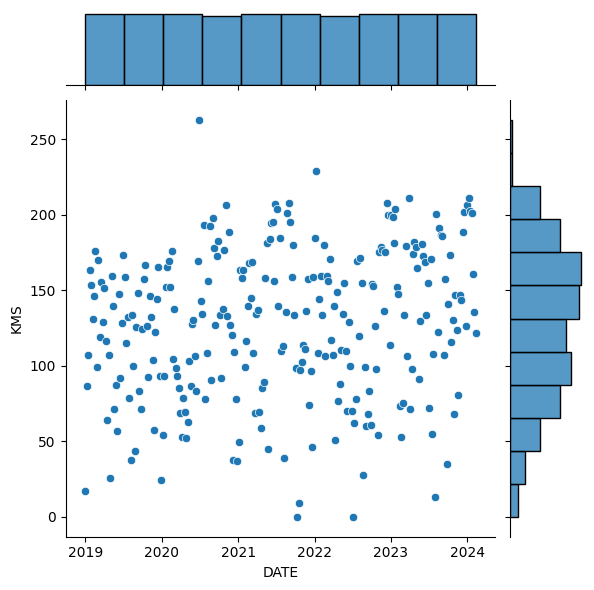

In [6]:
plt.figure(figsize=(18,6))
sns.jointplot(data=ivan, x="DATE", y="KMS");

#### Divición de los datos en entrenamiento y prueba

In [7]:
#cambiamos los nombres de las columnas dado que el paquete lo solicita
npivan=ivan.copy()
npivan=npivan.rename(columns={"DATE":"ds","KMS":"y"})
npivan

,ds,y
0,2018-12-31,17.3
1,2019-01-07,86.4
2,2019-01-14,107.3
3,2019-01-21,163.1
4,2019-01-28,153.5
...,...,...
263,2024-01-15,202.2
264,2024-01-22,200.9
265,2024-01-29,160.7
266,2024-02-05,135.7


### Importando el modelo NeuralProphet

In [8]:
from prophet import Prophet
from neuralprophet import NeuralProphet
from neuralprophet import NeuralProphet, set_log_level
from prophet.plot import plot_plotly, plot_components_plotly


from mlforecast.target_transforms import LocalRobustScaler, LocalStandardScaler

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
# Creando un modelo NeuralProphet
m = NeuralProphet()
m.set_plotting_backend("plotly-static")

In [13]:
# Dividimos los datos en entrenamiento y prueba
df_train, df_test=m.split_df(npivan, freq="W-MON", valid_p=0.20)

print("Dataset size:", len(npivan))
print("Train dataset size:", len(df_train))
print("Test dataset size:", len(df_test))

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


Dataset size: 268
Train dataset size: 215
Test dataset size: 53


In [14]:
#Entrenamos el modelo
metrics_train = m.fit(df=df_train, freq="W-MON")
metrics_test = m.test(df=df_test)

metrics_test

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.535% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (14) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.12473297864198685    │
│          MAE_val          │     47.39741134643555     │
│         RMSE_val          │    58.624717712402344     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,47.397411,58.624718,0.124733,0.0


In [15]:
#Predicciones
forecast=m.predict(npivan[["ds","y"]])
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly
0,2018-12-31,17.3,108.748535,102.410912,6.337623
1,2019-01-07,86.4,121.454285,103.745888,17.708393
2,2019-01-14,107.3,132.746140,105.080849,27.665277
3,2019-01-21,163.1,140.143265,106.415825,33.727425
4,2019-01-28,153.5,143.148849,107.750786,35.398045
...,...,...,...,...,...
263,2024-01-15,202.2,204.011414,175.483765,28.527647
264,2024-01-22,200.9,210.208618,176.103500,34.105118
265,2024-01-29,160.7,212.082001,176.723251,35.358734
266,2024-02-05,135.7,211.107941,177.343002,33.764950


In [ ]:
#Visualizacion de las predicciones
import kaleido

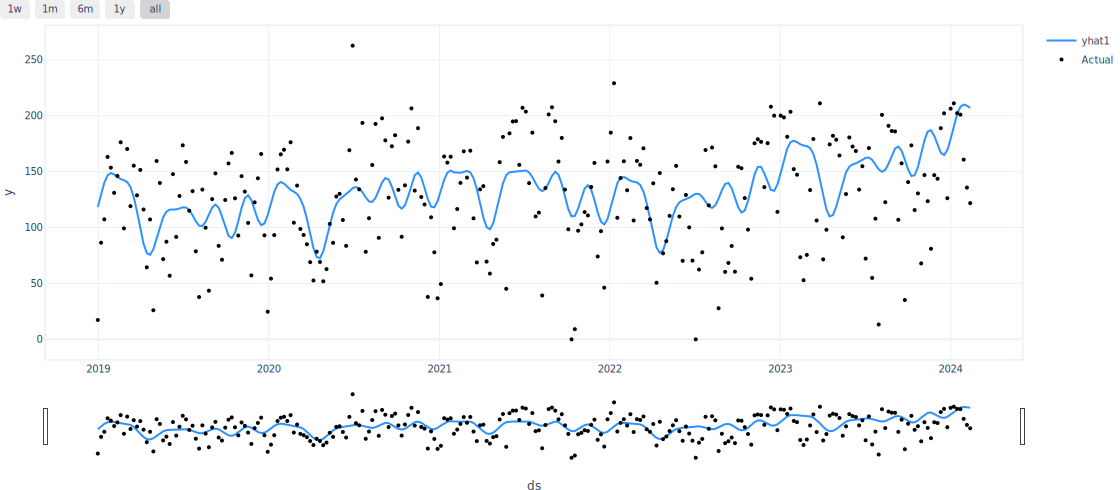

In [42]:
m.plot(forecast, figsize=(16,7))

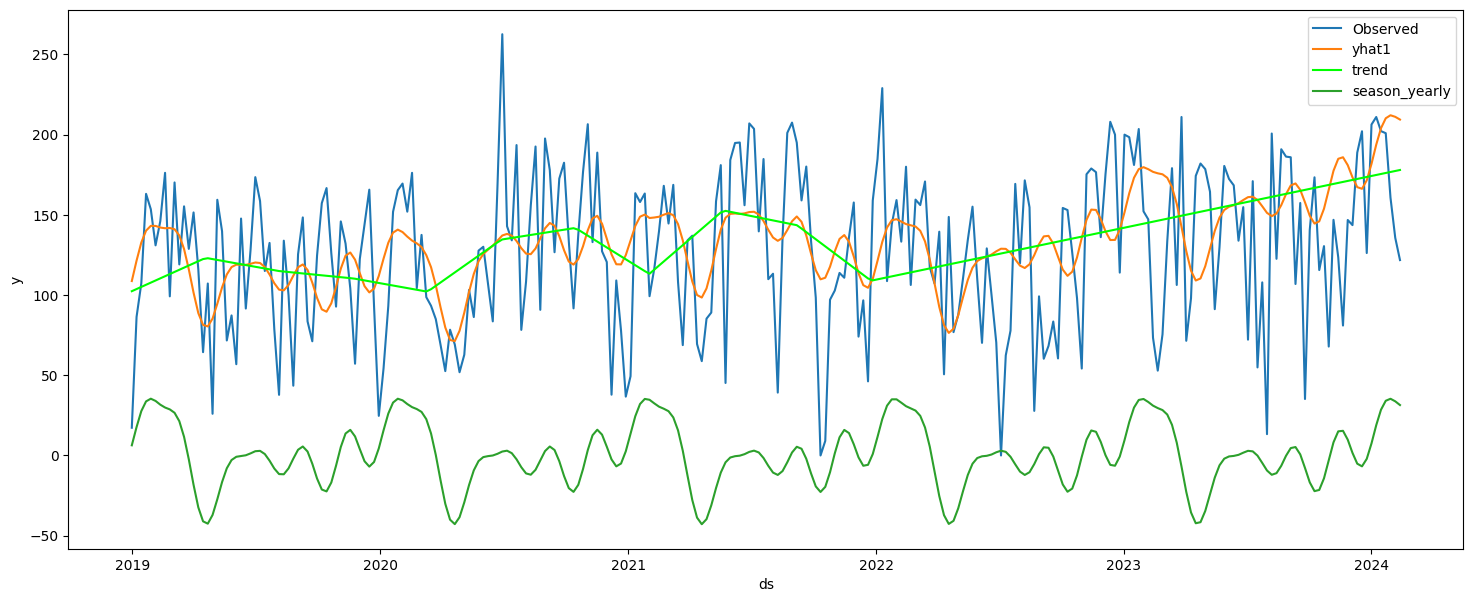

In [16]:
sns.lineplot(data=forecast, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast, x="ds", y="season_yearly", label="season_yearly")
plt.show()

In [ ]:
m.plot_parameters(figsize=(16,5))

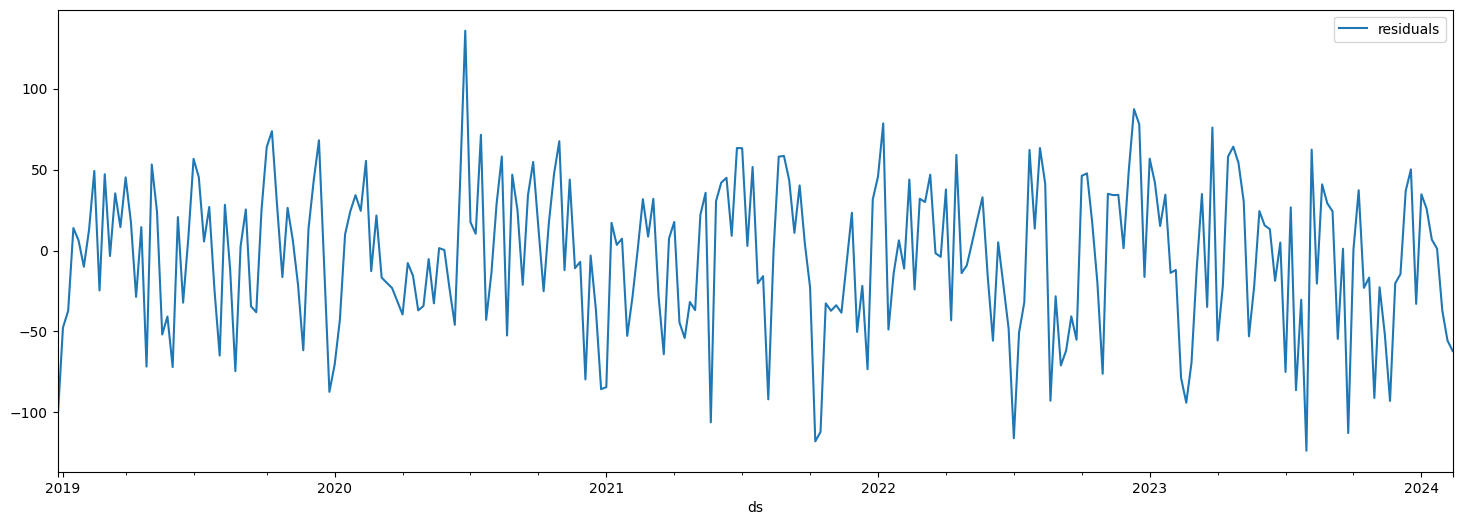

In [16]:
#Errores
df_residuals=pd.DataFrame({"ds":npivan["ds"], "residuals":npivan["y"]-forecast["yhat1"]})
fig=df_residuals.plot(x="ds", y="residuals", figsize=(18,6))

In [17]:
# Utilizando validacion cruzada
METRICS = ["MAE", "RMSE"]
METRICS_VAL = ["MAE_val", "RMSE_val"]
params = {"seasonality_mode": "additive"}

folds = NeuralProphet(**params).crossvalidation_split_df(npivan, freq="W-MON", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


In [20]:
metrics_train = pd.DataFrame(columns=METRICS)
metrics_test = pd.DataFrame(columns=METRICS_VAL)

for df_train, df_test in folds:
    m = NeuralProphet(**params)
    m.set_plotting_backend("plotly-static")
    train = m.fit(df=df_train, freq="W-MON")
    test = m.test(df=df_test)
    metrics_train = pd.concat([metrics_train, train[METRICS].iloc[[-1]]])
    metrics_test = pd.concat([metrics_test, test[METRICS_VAL].iloc[[-1]]])

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.065% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 240
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (7) is too small than the required number                     for the learnin

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.13896134495735168    │
│          MAE_val          │     43.30964279174805     │
│         RMSE_val          │     54.22598648071289     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.254% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 220
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (9) is too small than the required number                     for the learnin

Finding best initial lr:   0%|          | 0/209 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │     0.257642537355423     │
│          MAE_val          │     68.78964233398438     │
│         RMSE_val          │     84.7994613647461      │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.379% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 210
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (11) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/210 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.14622530341148376    │
│          MAE_val          │     50.08449172973633     │
│         RMSE_val          │     64.52542877197266     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.468% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 200
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (12) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/211 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.2563808858394623     │
│          MAE_val          │     76.42670440673828     │
│         RMSE_val          │     87.78242492675781     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.535% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (14) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.12166082859039307    │
│          MAE_val          │     46.82276916503906     │
│         RMSE_val          │     57.7506103515625      │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [21]:
metrics_test.describe().loc[["mean", "std", "min", "max"]]

,MAE_val,RMSE_val
mean,57.086650,69.816782
std,14.621740,15.523441
min,43.309643,54.225986
max,76.426704,87.782425


#### Agregando componente Auto-Regresiva

In [13]:
m1=NeuralProphet(
    #agregando 3 retardos
    n_lags=3,
    #agregando 2 capas ocultas a la parte autorregresiva
    lagged_reg_layers=2,)

In [14]:
#Entrenamos el modelo
metrics_train1 = m1.fit(df=df_train, freq="W-MON")
metrics_test1 = m1.test(df=df_test)

metrics_test1

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.535% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (14) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.09721213579177856    │
│          MAE_val          │    40.046260833740234     │
│         RMSE_val          │    50.392093658447266     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,40.046261,50.392094,0.097212,0.0


In [19]:
forecast1=m1.predict(npivan[["ds","y"]])
forecast1

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,ar1,trend,season_yearly
0,2018-12-31,17.3,NaN,NaN,NaN,NaN
1,2019-01-07,86.4,NaN,NaN,NaN,NaN
2,2019-01-14,107.3,NaN,NaN,NaN,NaN
3,2019-01-21,163.1,135.010376,-7.581354,110.302521,32.289204
4,2019-01-28,153.5,139.163467,4.772315,110.678436,23.712704
...,...,...,...,...,...,...
263,2024-01-15,202.2,198.161179,14.546053,147.659103,35.956024
264,2024-01-22,200.9,185.334457,5.826385,147.954468,31.553602
265,2024-01-29,160.7,176.274567,5.392175,148.249847,22.632540
266,2024-02-05,135.7,159.688950,-1.326856,148.545227,12.470590


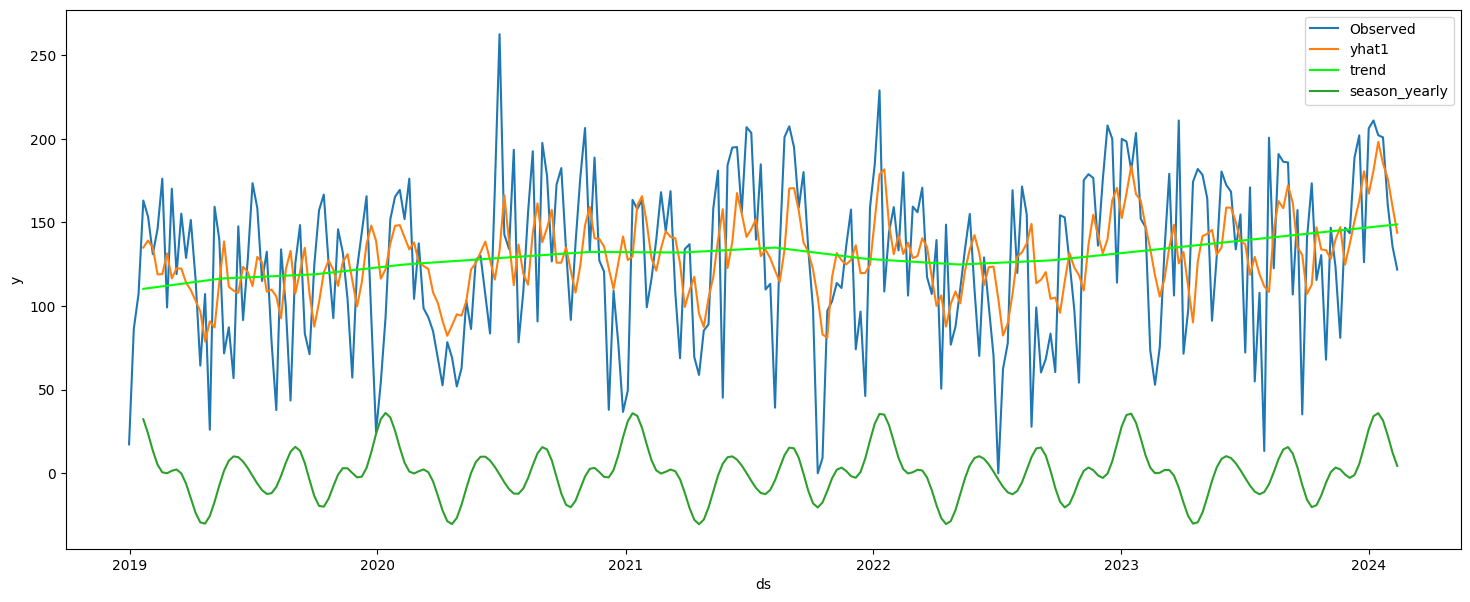

In [20]:
sns.lineplot(data=forecast1, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast1, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast1, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast1, x="ds", y="season_yearly", label="season_yearly")
plt.show()

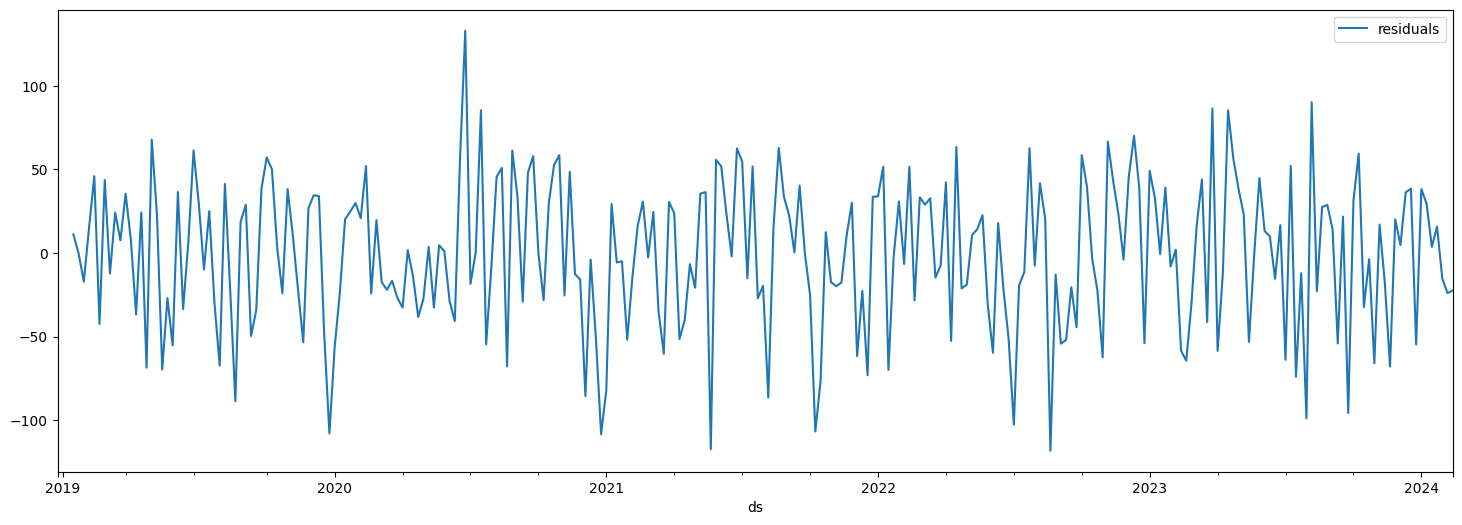

In [21]:
# residuales
df_residuals1=pd.DataFrame({"ds":npivan["ds"], "residuals":npivan["y"]-forecast1["yhat1"]})
fig=df_residuals1.plot(x="ds", y="residuals", figsize=(18,6))

#### Modelando la estacionalidad

In [15]:
m2=NeuralProphet(
    n_changepoints=30,
    yearly_seasonality=True,
    n_lags=3,)

In [16]:
#Entrenamos el modelo
metrics_train2 = m2.fit(df=df_train, freq="W-MON")
metrics_test2 = m2.test(df=df_test)

metrics_test2

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.535% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (14) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.10007180273532867    │
│          MAE_val          │     40.10767364501953     │
│         RMSE_val          │     51.40461349487305     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,40.107674,51.404613,0.100072,0.0


In [24]:
forecast2=m2.predict(npivan[["ds","y"]],)
forecast2

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Predicting: 17it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,ar1,trend,season_yearly
0,2018-12-31,17.3,NaN,NaN,NaN,NaN
1,2019-01-07,86.4,NaN,NaN,NaN,NaN
2,2019-01-14,107.3,NaN,NaN,NaN,NaN
3,2019-01-21,163.1,136.376907,-2.331207,107.526672,31.181433
4,2019-01-28,153.5,138.710861,6.797623,108.603935,23.309301
...,...,...,...,...,...,...
263,2024-01-15,202.2,193.128098,14.877169,143.962158,34.288769
264,2024-01-22,200.9,179.973358,5.432766,144.020462,30.520134
265,2024-01-29,160.7,171.487976,5.106746,144.078751,22.302477
266,2024-02-05,135.7,156.070282,-0.810400,144.137054,12.743615


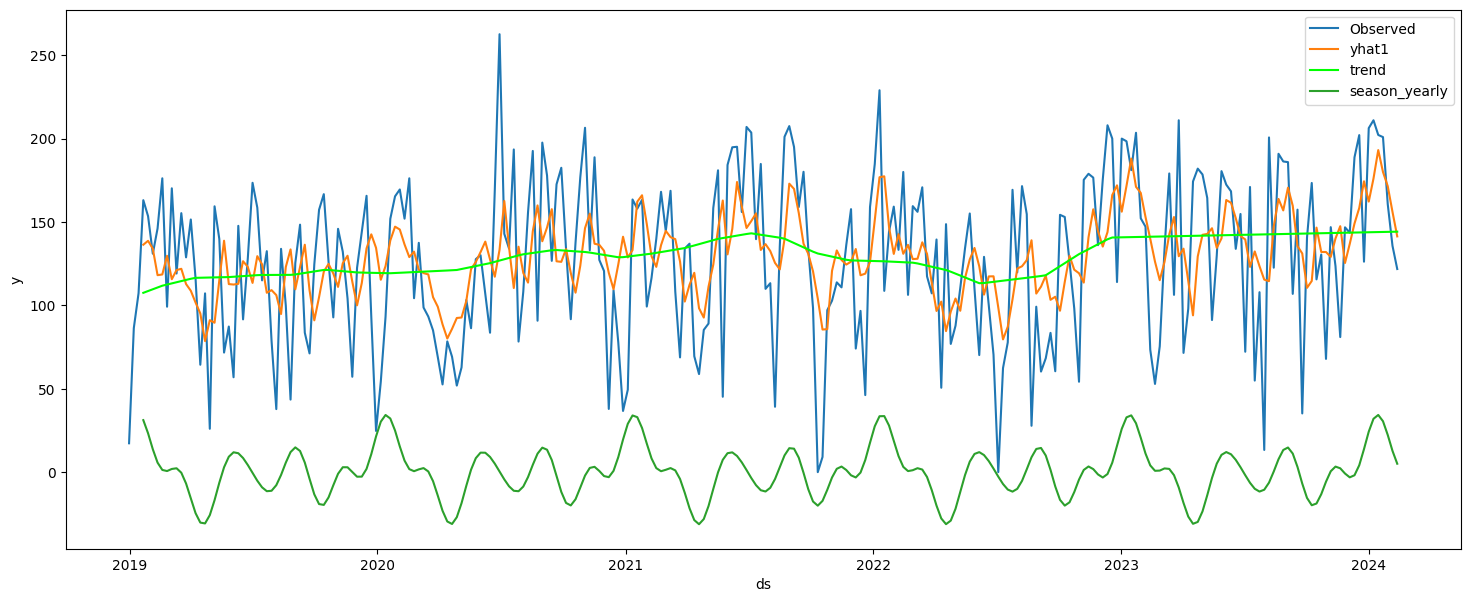

In [25]:
sns.lineplot(data=forecast2, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast2, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast2, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast2, x="ds", y="season_yearly", label="season_yearly")
plt.show()

#### Agregando componente estacional de forma manual

In [22]:
m2=NeuralProphet(
    n_changepoints=30,
    yearly_seasonality=True,
    n_lags=3,)

# Agregamos componente estacional mensual
m2 = m2.add_seasonality('quarterly', period=16.875, fourier_order=8)  #fourier_order=21

In [23]:
#Entrenamos el modelo
metrics_train2 = m2.fit(df=df_train, freq="W-MON")
metrics_test2 = m2.test(df=df_test)

metrics_test2

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.535% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 190
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (14) is too small than the required number                     for the learni

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.113% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.11551910638809204    │
│          MAE_val          │     42.6744384765625      │
│         RMSE_val          │     56.69184494018555     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,42.674438,56.691845,0.115519,0.0


In [25]:
forecast2=m2.predict(npivan[["ds","y"]],)
forecast2

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.627% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,ar1,trend,season_yearly,season_quarterly
0,2018-12-31,17.3,NaN,NaN,NaN,NaN,NaN
1,2019-01-07,86.4,NaN,NaN,NaN,NaN,NaN
2,2019-01-14,107.3,NaN,NaN,NaN,NaN,NaN
3,2019-01-21,163.1,133.354568,1.992407,91.911919,-43.848854,83.299103
4,2019-01-28,153.5,162.690094,8.051085,94.826233,-17.207458,77.020241
...,...,...,...,...,...,...,...
263,2024-01-15,202.2,203.634903,-4.150021,191.461578,-49.750813,66.074173
264,2024-01-22,200.9,200.117432,-0.578661,192.296478,-41.935524,50.335144
265,2024-01-29,160.7,181.660461,0.544439,193.131363,-13.341228,1.325886
266,2024-02-05,135.7,191.834976,-5.116686,193.966278,28.070572,-25.085186


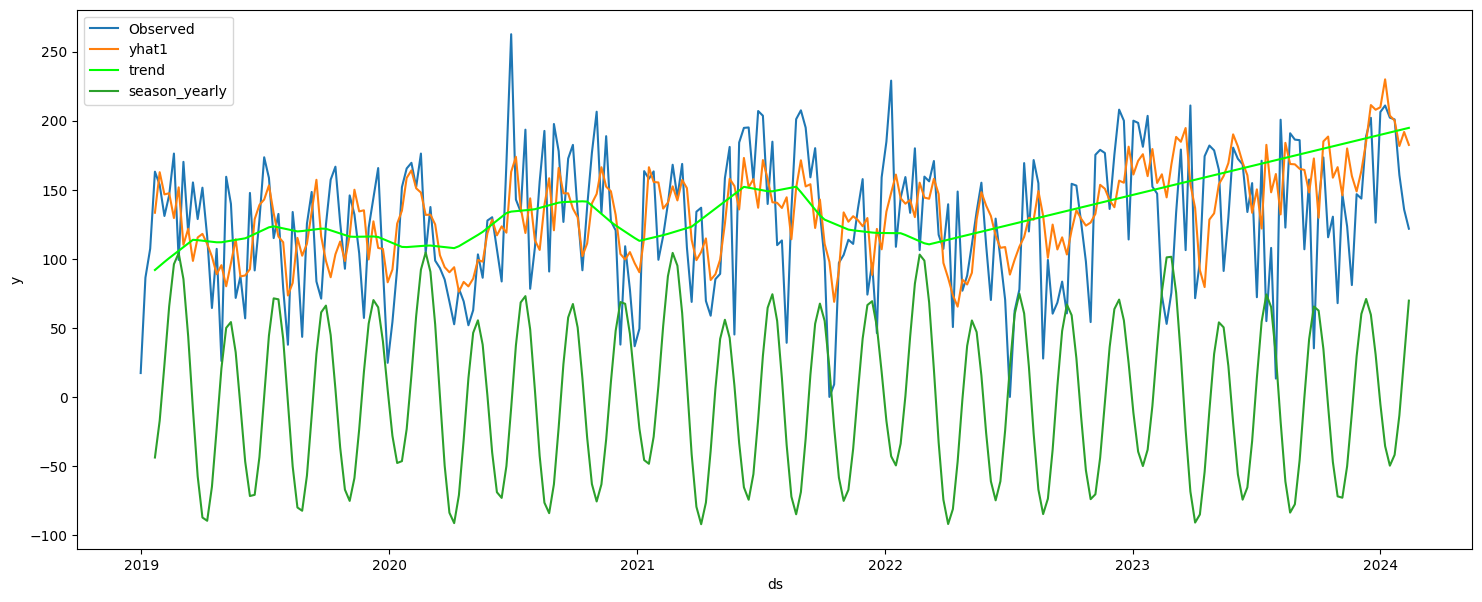

In [26]:
sns.lineplot(data=forecast2, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast2, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast2, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast2, x="ds", y="season_yearly", label="season_yearly")
plt.show()

#### Agregando variable exogena

In [31]:
df=pd.read_excel("Serie_Ivan.xlsx", usecols=["DATE","KMS","TIME"])
df.tail(8)

,DATE,KMS,TIME
260,2023-12-25,126.2,543
261,2024-01-01,206.3,839
262,2024-01-08,211.0,873
263,2024-01-15,202.2,867
264,2024-01-22,200.9,864
265,2024-01-29,160.7,680
266,2024-02-05,135.7,562
267,2024-02-12,121.8,494


In [32]:
npdf=df.copy()
npdf=npdf.rename(columns={"DATE":"ds","KMS":"y","TIME":"time"})
npdf

,ds,y,time
0,2018-12-31,17.3,64
1,2019-01-07,86.4,265
2,2019-01-14,107.3,472
3,2019-01-21,163.1,597
4,2019-01-28,153.5,648
...,...,...,...
263,2024-01-15,202.2,867
264,2024-01-22,200.9,864
265,2024-01-29,160.7,680
266,2024-02-05,135.7,562


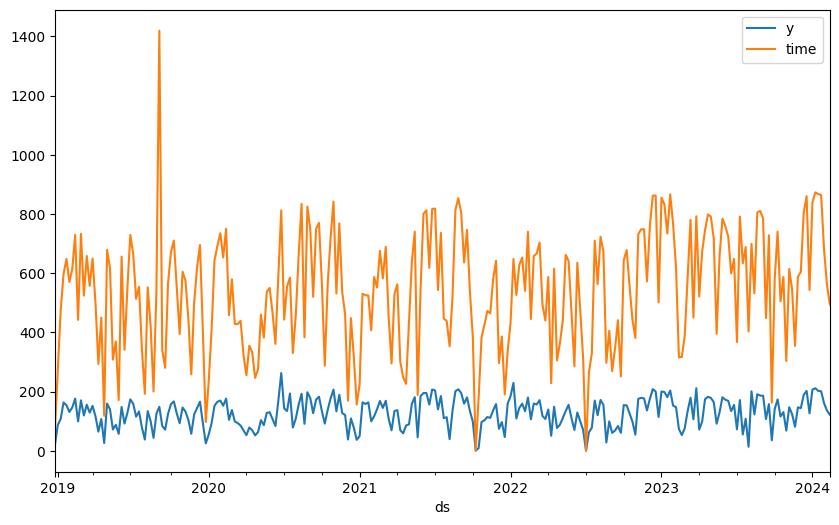

In [33]:
fig = npdf.plot(x="ds", y=["y", "time"], figsize=(10, 6))

In [34]:
#Desabilita mensajes entrantes menos si existe algun error
set_log_level("ERROR")

In [35]:
m4 = NeuralProphet(
     n_changepoints=10,
     yearly_seasonality=True,
     n_lags=3,
)
m4.set_plotting_backend("plotly-static")


# Agregamos el timepo empleado en los ultimos dos dias como regresor retardado
m4.add_lagged_regressor("time", n_lags=3)

In [36]:
# Dividimos los datos en entrenamiento y prueba
df_train, df_test=m.split_df(npdf, freq="W-MON", valid_p=0.20)

print("Dataset size:", len(npivan))
print("Train dataset size:", len(df_train))
print("Test dataset size:", len(df_test))

Dataset size: 268
Train dataset size: 215
Test dataset size: 53


In [24]:
# Continuamos ajustando el modelo y haciendo las predicciones
metrics_train4 = m4.fit(df=df_train, freq="W-MON")
metrics_test4 = m4.test(df=df_test)

metrics_test4

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.09761116653680801    │
│          MAE_val          │    39.644142150878906     │
│         RMSE_val          │     50.39183807373047     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,39.644142,50.391838,0.097611,0.0


In [25]:
# Predicciones
forecast4 = m4.predict(npdf)

Predicting: 14it [00:00, ?it/s]

In [ ]:
m4.highlight_nth_step_ahead_of_each_forecast(1)
m4.plot(forecast4)

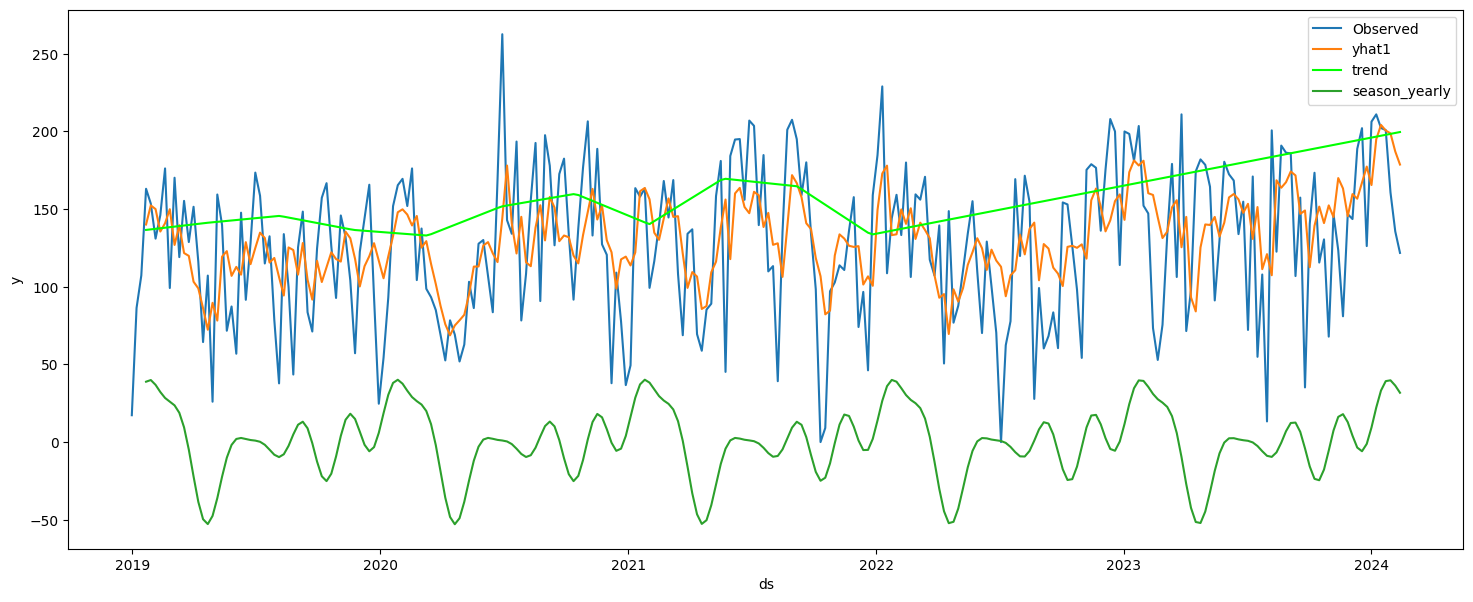

In [26]:
sns.lineplot(data=forecast4, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast4, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast4, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast4, x="ds", y="season_yearly", label="season_yearly")
plt.show()

In [ ]:
# Visualizar los parametros del modelo para las variables exogenas retardadas
m4.plot_parameters(components=["lagged_regressors"])

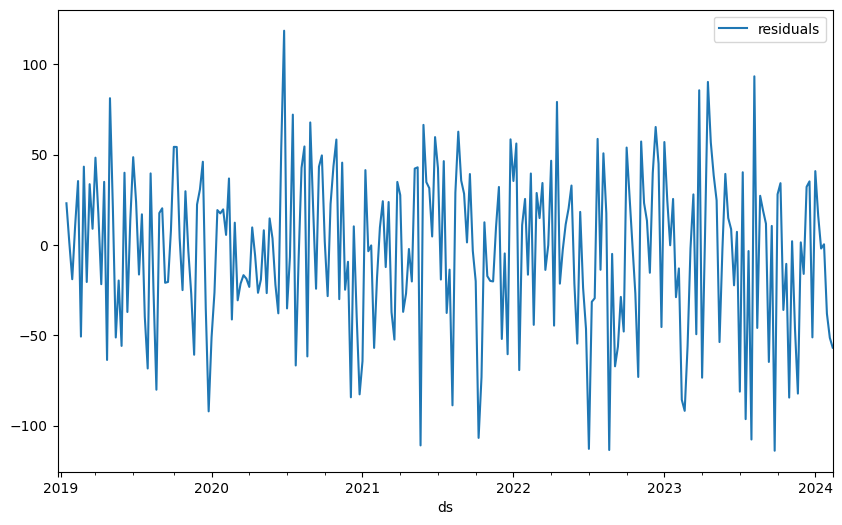

In [27]:
# Errores
df_residuals = pd.DataFrame({"ds": npdf["ds"], "residuals": npdf["y"] - forecast4["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

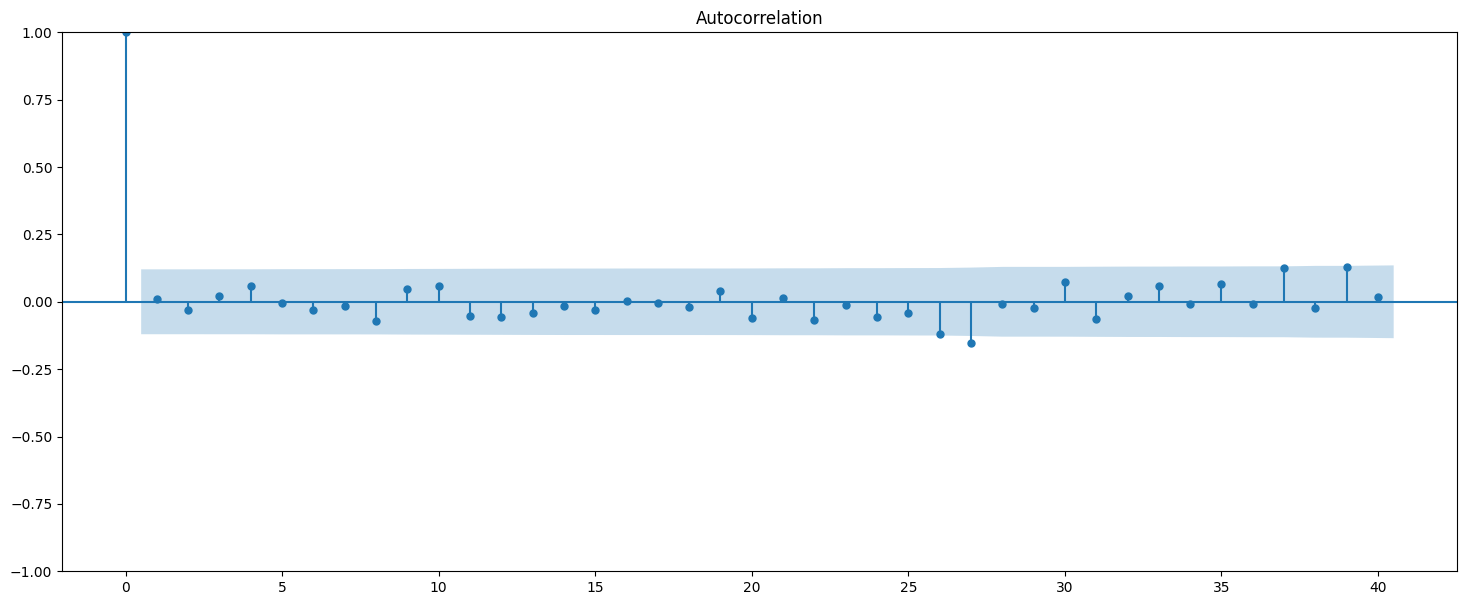

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"].dropna(), lags=40)

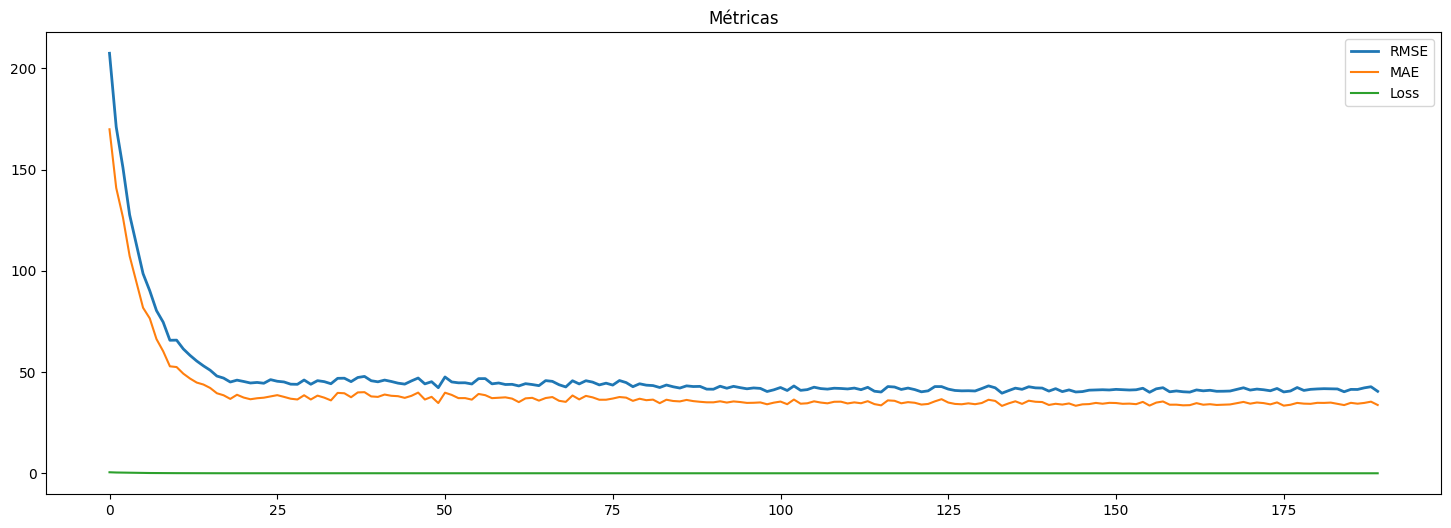

In [33]:
metrics_train4['RMSE'].plot(linewidth=2, figsize=(18,6), title="Métricas", legend="RMSE")
metrics_train4['MAE'].plot(legend="MAE")
metrics_train4['Loss'].plot(legend="Loss")
plt.show()

#### Añadiendo Eventos y Días Festivos

In [34]:
m5 = NeuralProphet(
     n_changepoints=10,
     yearly_seasonality=True,
     n_lags=3,
)
m5.set_plotting_backend("plotly-static")


# Agregamos el timepo empleado en los ultimos dos dias como regresor retardado
m5.add_lagged_regressor("time", n_lags=3)

# Agregamos dias festivos en colombia
m5 = m5.add_country_holidays("CO")

# Continuamos ajustando el modelo y haciendo las predicciones
metrics_train5 = m5.fit(df=df_train, freq="W-MON")
metrics_test5 = m5.test(df=df_test)

metrics_test5

forecast5 = m5.predict(npdf)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.0998830795288086     │
│          MAE_val          │    40.317623138427734     │
│         RMSE_val          │     51.23109817504883     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: 14it [00:00, ?it/s]

In [ ]:
m5.plot(forecast5)

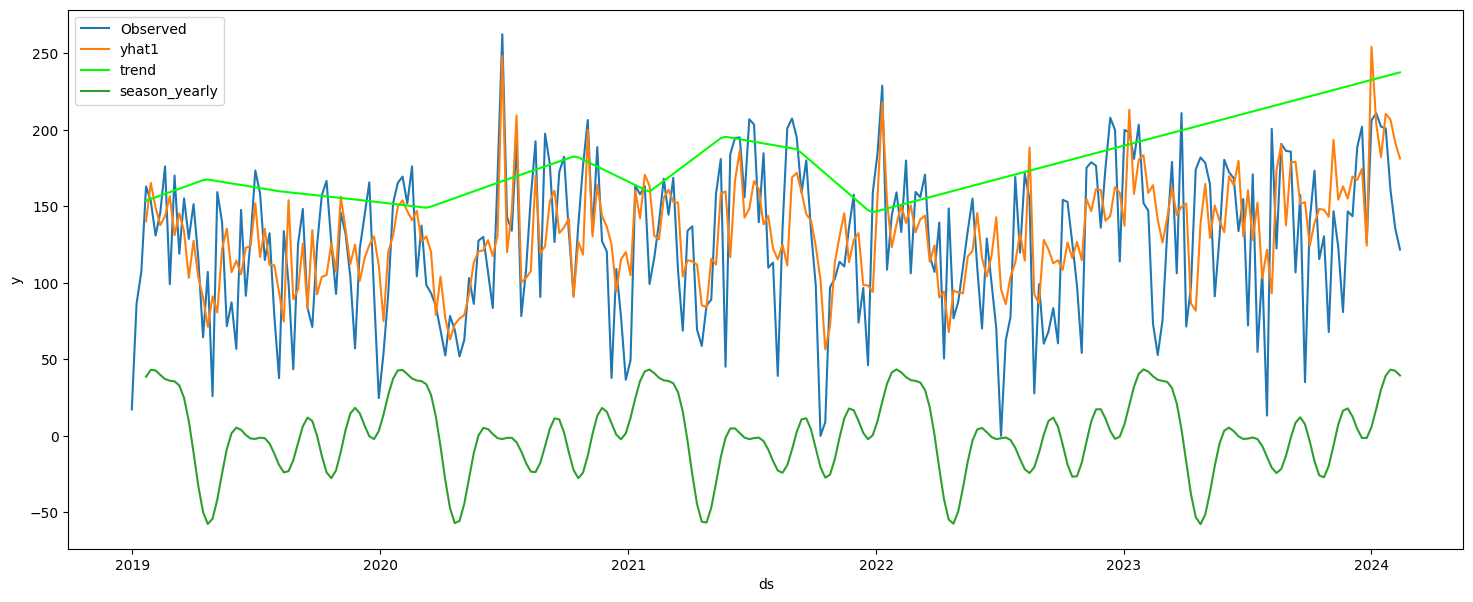

In [35]:
sns.lineplot(data=forecast5, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast5, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast5, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast5, x="ds", y="season_yearly", label="season_yearly")
plt.show()

#### Agregando estacionalidad mensual

In [36]:
m6 = NeuralProphet(
     n_changepoints=10,
     yearly_seasonality=True,
     n_lags=3,
)
m6.set_plotting_backend("plotly-static")


# Agregamos el timepo empleado en los ultimos dos dias como regresor retardado
m6.add_lagged_regressor("time", n_lags=3)

# Agregamos dias festivos en colombia
m6 = m6.add_country_holidays("CO")

# Agregamos componente estacional mensual
m6 = m6.add_seasonality('quarterly', period=16.875, fourier_order=8)

# Continuamos ajustando el modelo y haciendo las predicciones
metrics_train6 = m6.fit(df=df_train, freq="W-MON")
metrics_test6 = m6.test(df=df_test)

metrics_test6

forecast6 = m6.predict(npdf)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.08813278377056122    │
│          MAE_val          │    39.933677673339844     │
│         RMSE_val          │     48.05104064941406     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

Predicting: 14it [00:00, ?it/s]

In [ ]:
m6.plot(forecast6)

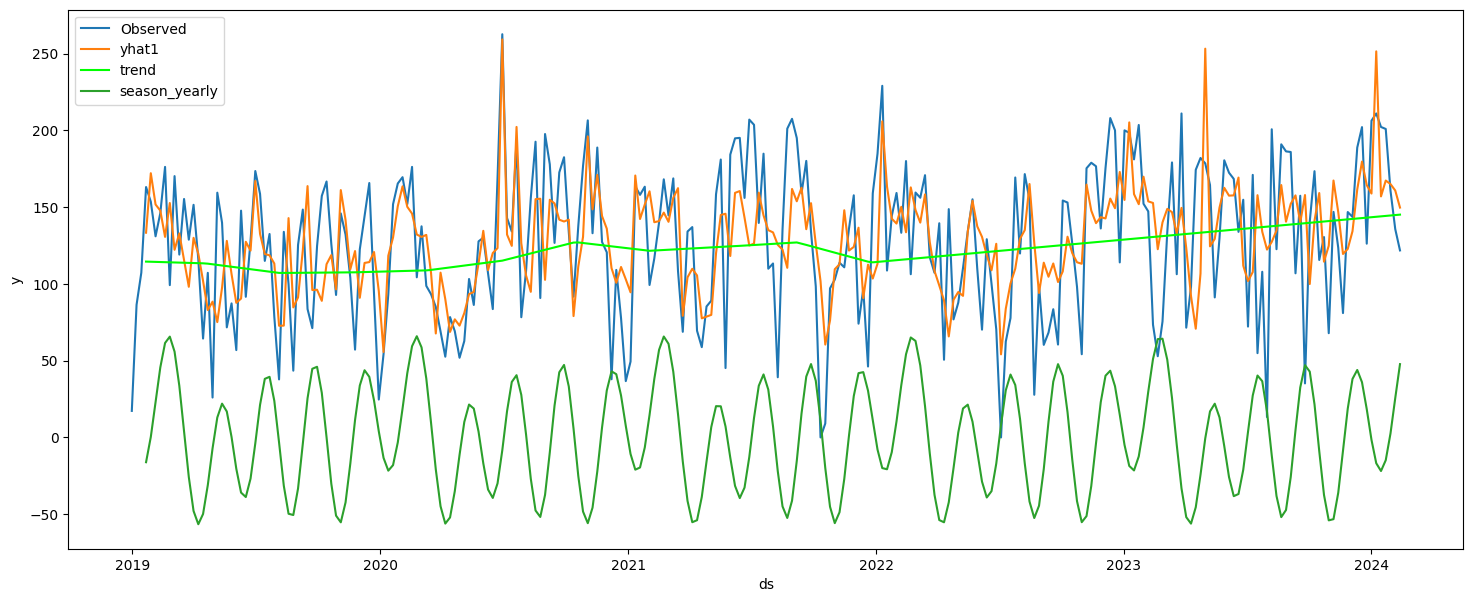

In [37]:
sns.lineplot(data=forecast6, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast6, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast6, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast6, x="ds", y="season_yearly", label="season_yearly")
plt.show()

In [37]:
# Modelando con 21 componentes de Fourier
m7 = NeuralProphet(
     n_changepoints=10,
     yearly_seasonality=True,
     n_lags=3,
)
m7.set_plotting_backend("plotly-static")


# Agregamos el timepo empleado en los ultimos dos dias como regresor retardado
m7.add_lagged_regressor("time", n_lags=3)

# Agregamos dias festivos en colombia
m7 = m7.add_country_holidays("CO")

# Agregamos componente estacional mensual
m7 = m7.add_seasonality('quarterly', period=16.875, fourier_order=21)

# Continuamos ajustando el modelo y haciendo las predicciones
metrics7 = m7.fit(df=df_train)
forecast7 = m7.predict(df=df_test)

Finding best initial lr:   0%|          | 0/212 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

In [40]:
metrics_test=m7.test(df=df_test)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │    0.13762566447257996    │
│          MAE_val          │     49.74360656738281     │
│         RMSE_val          │     66.7464370727539      │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [ ]:
m7.plot(forecast7)

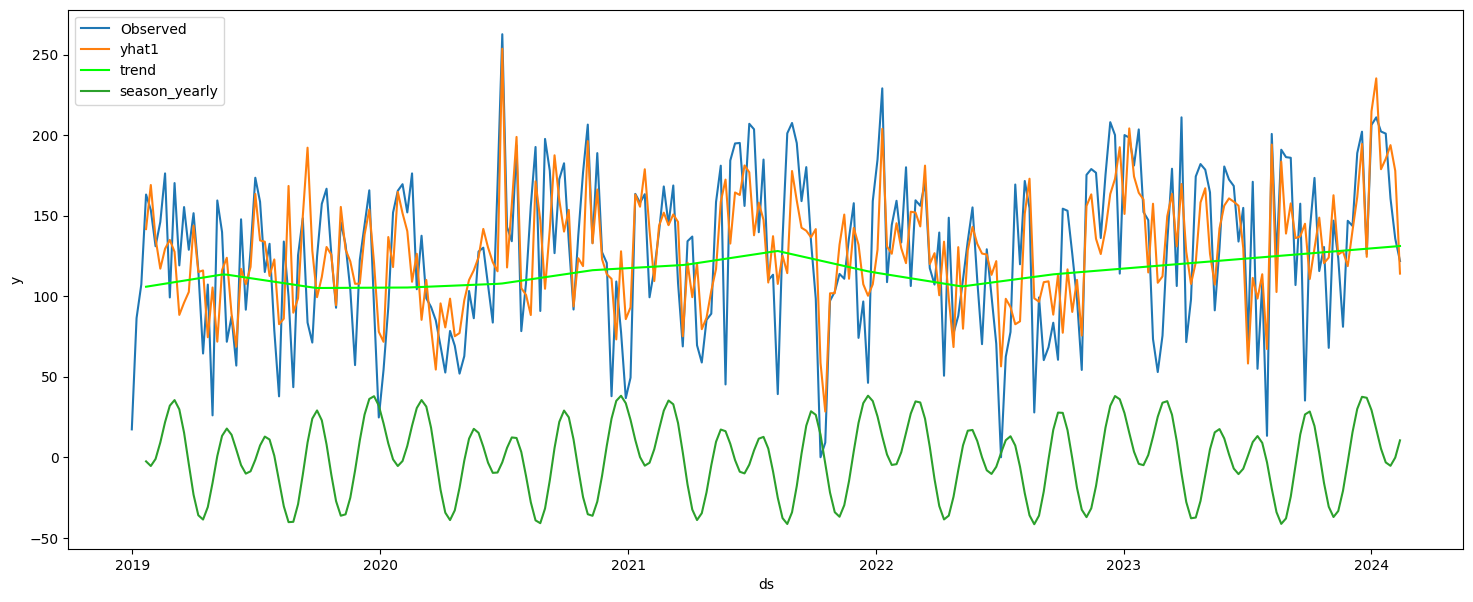

In [35]:
sns.lineplot(data=forecast7, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast7, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast7, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast7, x="ds", y="season_yearly", label="season_yearly")
plt.show()

In [36]:
#RMSE
metrics7.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
169,29.509598,36.838619,0.041162,0.0,169


#### Agregando eventos especiales

In [39]:
df_events = pd.DataFrame(
    {
        "event": "kms_cero",
        "ds": pd.to_datetime(
            [
                "2022-07-04",
                "2021-10-11",
                "2020-04-27",
                "2020-04-20",
                "2020-04-13",
                "2020-04-06",
                "2020-03-30",
                "2020-03-23",
            ]
        ),
    }
)

In [39]:
m8 = NeuralProphet(
     n_changepoints=10,
     yearly_seasonality=True,
     n_lags=3,
)
m8.set_plotting_backend("plotly-static")


# Agregamos el timepo empleado en los ultimos dos dias como regresor retardado
m8.add_lagged_regressor("time", n_lags=3)

# Agregamos dias festivos en colombia
m8 = m8.add_country_holidays("CO")

# Agregamos componente estacional mensual
m8 = m8.add_seasonality('quarterly', period=16.875, fourier_order=8)

# Agregamos eventos donde Ivan no corrio
m8.add_events("kms_cero")

npdf_all = m8.create_df_with_events(npdf, df_events)



# Continuamos ajustando el modelo y haciendo las predicciones
metrics8 = m8.fit(npdf_all)

forecast8 = m8.predict(npdf_all)

Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 17it [00:00, ?it/s]

In [ ]:
m8.plot(forecast8)

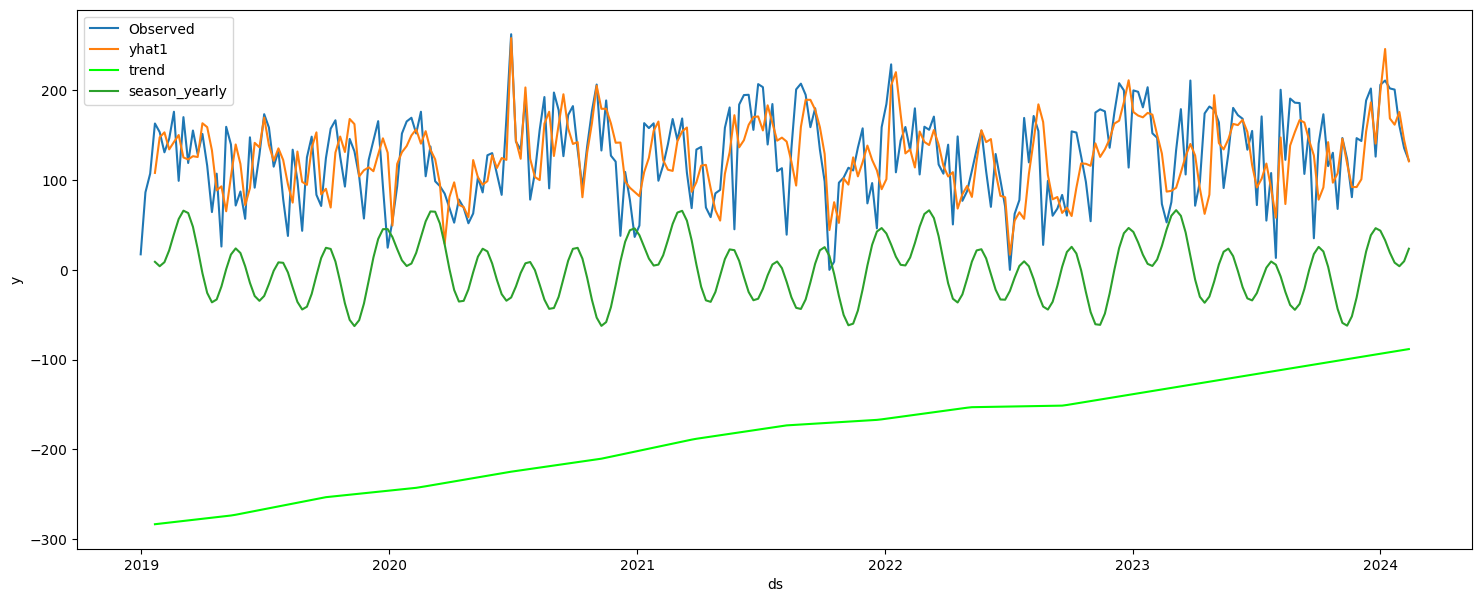

In [40]:
sns.lineplot(data=forecast8, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast8, x="ds", y="yhat1", label="yhat1")
sns.lineplot(data=forecast8, x="ds", y="trend", label="trend",  color="lime")
sns.lineplot(data=forecast8, x="ds", y="season_yearly", label="season_yearly")
plt.show()

In [41]:
#RMSE
metrics8.tail(1)

,MAE,RMSE,Loss,RegLoss,epoch
169,34.143547,42.749405,0.055462,0.0,169


In [ ]:
m8.plot(forecast8)